In [1]:
# Project Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, Dict

# Paths
data_dir = '../data/jp_morgan'

In [2]:
# Load data
aml_data = pd.read_csv(f'{data_dir}/aml_syn_data.csv')
# fraud_data = pd.read_csv(f'{data_dir}/fraud_payment_data.csv')



In [3]:
common_columns = [
    'Time_step',
    'Label',
    'Transaction_Id',
    'Transaction_Type',
    'Sender_Id',
    'Sender_Account',
    'Sender_Country',
    'Bene_Id', 
    'Bene_Account',
    'Bene_Country',
    'USD_amount',
]
aml_data = aml_data[common_columns]
# fraud_data = fraud_data[common_columns]

In [4]:
aml_data[['Transaction_Type']].drop_duplicates()

,Transaction_Type
0,KYC-ADD-ACCOUNT-OWNER
3,WIRE
10,KYC-CREATE-ACCOUNT
12,PAYMENT
73,WITHDRAWL
331,CASH-DEPOSIT
10071,CRYPTO-TRANSFER


Feature Columns:
* hour of transaction
* normalised age on transaction

Data Preprocessing
1. Filter only transactions considering money movements
2. Retable DataFrame to be in Party v Counterparty format

In [4]:
# AML Data Preprocessing
# Filter only money movements
aml_data = aml_data[aml_data['Transaction_Type'].isin(['WIRE', 'PAYMENT', 'WITHDRAWL', 'CASH-DEPOSIT', 'CRYPTO-TRANSFER'])].reset_index()

# Identify if row is reversed for party v counterparty retabling
def party_reverse_flag(
        df: pd.DataFrame, 
        sender_col: str = 'Sender_Id', 
        bene_col: str = 'Bene_Id', 
        transaction_col: str = 'Transaction_Type'
        ) -> pd.DataFrame:

    df.loc[:, 'sender_type'] = df[sender_col].str.split('-').str[:2].str.join('-')
    df.loc[:, 'benef_type'] = df[bene_col].str.split('-').str[:2].str.join('-')
    condition = (
        (df[transaction_col] == 'CASH-DEPOSIT') |
        ((df[transaction_col] == 'WIRE') & (df['benef_type'] == 'JPMC-CLIENT'))
    )
    df.loc[:, 'is_credit'] = condition
    df.loc[:, 'reversed'] = condition
    return df

aml_data = party_reverse_flag(aml_data)

In [5]:
# Create party v counterparty retabling
def new_table(
        df: pd.DataFrame, 
        rev_col: str = 'reversed', 
        retained_cols: Optional[List[str]] = None
        ) -> pd.DataFrame:

    for type in ('Id', 'Account', 'Country'):
        df.loc[:, f'party_{type}'] = df[f'Sender_{type}'].where(~df[rev_col], df[f'Bene_{type}'])
        df.loc[:, f'cparty_{type}'] = df[f'Bene_{type}'].where(~df[rev_col], df[f'Sender_{type}'])
    retained_cols.extend(['party_Id', 'party_Account', 'party_Country',
                          'cparty_Id', 'cparty_Account', 'cparty_Country'])
    new_table = df[retained_cols]
    return new_table

aml_data = new_table(aml_data, retained_cols=[
    'Time_step', 
    'Label',
    'Transaction_Id',
    'Transaction_Type',
    'is_credit',
    'USD_amount'
    ])

3. Normalise dates (change into age of account on transaction) and extract hour/minute for off hours transaction

In [6]:
# Normalise date and extract hour minutes
def feature_time(
        df: pd.DataFrame, 
        dt_column: str = 'Time_step'
        ) -> pd.DataFrame:
    
    time_series = pd.to_datetime(df[dt_column])
    df['txn_time_hr'] = time_series.dt.hour
    df['txn_time_mm'] = time_series.dt.minute
    
    return df

def normalise_date(df, dt_column='Time_step', primary_col='party_Id'):
    time_series = pd.to_datetime(df[dt_column]).dt.date
    df['txn_age_days'] = (time_series - time_series.groupby(df[primary_col]).transform('min')).astype('timedelta64[ns]').dt.days
    
    return df

aml_data = feature_time(aml_data)
aml_data = normalise_date(aml_data)


4. Collect previous transaction details: (transaction type, amount, if applicable delta between transactions)

In [7]:
# Extract previous transaction details
dt_norm_values = {
    'day': 'txn_age_days',
    'hour': 'txn_time_hr',
    'min': 'txn_time_mm',
}
def fill_prev_txn(
        df: pd.DataFrame, 
        primary_key: str = 'party_Id', 
        dt_column: str | None = None,
        dt_norm_columns: Dict[str, str] | None = None, 
        columns_to_fill: List[str] = [], 
        shift: int = 1, 
        include_age_delta: bool = False
        ) -> pd.DataFrame:
    
    if dt_column != None:
        core_columns = [primary_key, dt_column]
        temp_df = df[core_columns + columns_to_fill].copy()

        temp_df[dt_column] = pd.to_datetime(temp_df[dt_column])
        temp_df = temp_df.sort_values([primary_key, dt_column])
        
        temp_df['prev_age_delta'] = (
            (temp_df[dt_column] - temp_df.groupby(primary_key)[dt_column].shift(shift))
            .dt.total_seconds())/(24 * 3600)

        
    else:
        dt_norm_cols = [dt_norm_columns['day'], dt_norm_columns['hour'], dt_norm_columns['min']]
        core_columns = [primary_key] + dt_norm_cols
        temp_df = df[core_columns + columns_to_fill].copy()
        
        temp_df = temp_df.sort_values(by=[primary_key] + dt_norm_cols, ascending=True)
        temp_df['rel_age'] = (
            temp_df[dt_norm_columns['day']] + 
            (temp_df[dt_norm_columns['hour']] / 24) + 
            (temp_df[dt_norm_columns['min']] / (24 * 60))
            )
        temp_df['prev_age_delta'] = temp_df['rel_age'] - temp_df.groupby(primary_key)['rel_age'].shift(shift)
    
    new_columns = ['prev_' + col for col in columns_to_fill]

    temp_df[new_columns] = temp_df.groupby(primary_key)[columns_to_fill].shift(shift)
    if include_age_delta:
        new_columns.append('prev_age_delta')
    
    return df.merge(temp_df[new_columns], left_index=True, right_index=True)

aml_data = fill_prev_txn(aml_data, dt_norm_columns=dt_norm_values, columns_to_fill=['Transaction_Type', 'USD_amount'], include_age_delta=True)

In [ ]:
# Transaction Volume Deviation
def cust_running_txn_vol(
        df: pd.DataFrame, 
        bin: List[float], 
        primary_key: str = 'party_Id', 
        amt_col: str = 'USD_amount', 
        dt_column: str = 'Time_step'
        ) -> None:

    core_columns = [primary_key, dt_column, amt_col]
    temp_df = df[core_columns].copy()

    temp_df[dt_column] = pd.to_datetime(temp_df[dt_column])
    temp_df = temp_df.sort_values([primary_key, dt_column])
    for b in bin:


In [11]:
import pandas as pd
import numpy as np
from typing import List, Dict, Union, Tuple
from datetime import datetime, timedelta

class TransactionStatsCalculator:
    def __init__(
        self,
        time_bins: List[int] = [7, 14, 30],
        metrics: List[str] = ['avg', 'std', 'count'],
        ratio_pairs: List[Tuple[int, int]] = [(7, 14), (7, 30), (14, 30)]
    ):
        """
        Initialize the transaction statistics calculator
        
        Parameters:
        -----------
        time_bins : List[int]
            List of time windows in days to calculate metrics for
        metrics : List[str]
            List of metrics to calculate
        ratio_pairs : List[tuple]
            List of time bin pairs to calculate ratios for
        """
        self.time_bins = sorted(time_bins)
        self.metrics = metrics
        self.ratio_pairs = ratio_pairs
        self._validate_ratio_pairs()
        
    def _validate_ratio_pairs(self) -> None:
        """Validate that ratio pairs use existing time bins"""
        all_periods = set(self.time_bins)
        for from_days, to_days in self.ratio_pairs:
            if from_days not in all_periods or to_days not in all_periods:
                raise ValueError(
                    f"Ratio pair ({from_days}, {to_days}) uses undefined time bin"
                )

    def _validate_inputs(
        self,
        df: pd.DataFrame,
        amount_col: str,
        customer_id_col: str,
        age_col: str
    ) -> None:
        """Validate input DataFrame and column names"""
        required_cols = [amount_col, customer_id_col, age_col]
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

    def calculate_window_stats(
        self,
        df: pd.DataFrame,
        reference_age: float,
        window_days: int,
        amount_col: str = 'amount',
        age_col: str = 'account_age'
    ) -> Dict[str, float]:
        """
        Calculate statistics for a specific time window using account age
        """
        # Calculate window boundaries (up to day-1)
        end_age = reference_age - 1  # day-1
        start_age = end_age - window_days
        
        # Filter data for the time window
        mask = (df[age_col] <= end_age) & (df[age_col] > start_age)
        window_data = df.loc[mask, amount_col]
        
        stats = {}
        if len(window_data) > 0:
            if 'avg' in self.metrics:
                stats[f'volume_{window_days}d_avg'] = float(window_data.mean())
            if 'std' in self.metrics:
                stats[f'volume_{window_days}d_std'] = float(window_data.std()) if len(window_data) > 1 else 0.0
            if 'count' in self.metrics:
                stats[f'volume_{window_days}d_count'] = int(len(window_data))
        else:
            # Handle empty windows
            for metric in self.metrics:
                stats[f'volume_{window_days}d_{metric}'] = 0.0
                
        return stats

    def calculate_ratios(
        self,
        stats: Dict[str, float]
    ) -> Dict[str, float]:
        """Calculate ratios between different time periods"""
        ratio_stats = {}
        
        for from_days, to_days in self.ratio_pairs:
            # Volume average ratio
            if 'avg' in self.metrics:
                ratio_name = f'volume_avg_{from_days}d_to_{to_days}d_ratio'
                from_avg = stats.get(f'volume_{from_days}d_avg', 0)
                to_avg = stats.get(f'volume_{to_days}d_avg', 0)
                ratio_stats[ratio_name] = from_avg / to_avg if to_avg != 0 else 0
                
            # Count ratio (normalized by time period)
            if 'count' in self.metrics:
                ratio_name = f'volume_count_{from_days}d_to_{to_days}d_ratio'
                from_count = stats.get(f'volume_{from_days}d_count', 0)
                to_count = stats.get(f'volume_{to_days}d_count', 0)
                normalized_ratio = (from_count / from_days) / (to_count / to_days) if to_count != 0 else 0
                ratio_stats[ratio_name] = normalized_ratio
                
        return ratio_stats

    def calculate_transaction_stats(
        self,
        df: pd.DataFrame,
        current_transaction: pd.Series,
        amount_col: str = 'amount',
        customer_id_col: str = 'customer_id',
        age_col: str = 'account_age'
    ) -> Dict[str, float]:
        """Calculate all statistics for a single transaction"""
        # Get customer's transactions up to this point
        customer_df = df[
            (df[customer_id_col] == current_transaction[customer_id_col]) &
            (df[age_col] < current_transaction[age_col])
        ].copy()
        
        # Calculate stats for each time bin
        all_stats = {}
        for days in self.time_bins:
            window_stats = self.calculate_window_stats(
                df=customer_df,
                reference_age=current_transaction[age_col],
                window_days=days,
                amount_col=amount_col,
                age_col=age_col
            )
            all_stats.update(window_stats)
        
        # Calculate ratios
        ratio_stats = self.calculate_ratios(all_stats)
        all_stats.update(ratio_stats)
        
        return all_stats

    def _initialize_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Initialize all metric columns in the DataFrame"""
        # Generate column names
        metric_columns = [
            f'volume_{days}d_{metric}'
            for days in self.time_bins
            for metric in self.metrics
        ]
        ratio_columns = [
            f'volume_{metric}_{from_d}d_to_{to_d}d_ratio'
            for from_d, to_d in self.ratio_pairs
            for metric in ['avg', 'count'] if metric in self.metrics
        ]
        
        # Initialize columns with zeros
        for col in metric_columns + ratio_columns:
            df[col] = 0.0
            
        return df

    def process_transactions(
        self,
        df: pd.DataFrame,
        amount_col: str = 'amount',
        customer_id_col: str = 'customer_id',
        age_col: str = 'account_age'
    ) -> pd.DataFrame:
        """Process all transactions and add statistics columns"""
        # Validate inputs
        self._validate_inputs(df, amount_col, customer_id_col, age_col)
        
        # Sort and copy data
        df = df.sort_values([customer_id_col, age_col]).copy()
        
        # Initialize metric columns
        df = self._initialize_columns(df)
        
        # Calculate metrics for each transaction
        for idx, row in df.iterrows():
            stats = self.calculate_transaction_stats(
                df=df,
                current_transaction=row,
                amount_col=amount_col,
                customer_id_col=customer_id_col,
                age_col=age_col
            )
            
            # Update row with calculated stats
            for metric, value in stats.items():
                df.at[idx, metric] = value
        
        return df

    def get_column_names(self) -> List[str]:
        """Get list of all metric column names"""
        metric_columns = [
            f'volume_{days}d_{metric}'
            for days in self.time_bins
            for metric in self.metrics
        ]
        ratio_columns = [
            f'volume_{metric}_{from_d}d_to_{to_d}d_ratio'
            for from_d, to_d in self.ratio_pairs
            for metric in ['avg', 'count'] if metric in self.metrics
        ]
        return metric_columns + ratio_columns

# Example usage
def example_usage():
    # Create sample data
    data = {
        'customer_id': ['A1', 'A1', 'A1', 'A2', 'A2'],
        'amount': [100, 200, 150, 300, 250],
        'account_age': [10, 20, 30, 15, 25]  # normalized days
    }
    df = pd.DataFrame(data)
    
    # Initialize calculator with custom configuration
    calculator = TransactionStatsCalculator(
        time_bins=[7, 14, 30],
        metrics=['avg', 'std', 'count'],
        ratio_pairs=[(7, 14), (7, 30), (14, 30)]
    )
    
    # Process transactions
    result_df = calculator.process_transactions(
        df=df,
        amount_col='amount',
        customer_id_col='customer_id',
        age_col='account_age'
    )
    
    # Get column names
    columns = calculator.get_column_names()
    
    return result_df



,customer_id,amount,account_age,volume_7d_avg,volume_7d_std,volume_7d_count,volume_14d_avg,volume_14d_std,volume_14d_count,volume_30d_avg,volume_30d_std,volume_30d_count,volume_avg_7d_to_14d_ratio,volume_count_7d_to_14d_ratio,volume_avg_7d_to_30d_ratio,volume_count_7d_to_30d_ratio,volume_avg_14d_to_30d_ratio,volume_count_14d_to_30d_ratio
0,A1,100,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,A1,200,20,0.0,0.0,0.0,100.0,0.0,1.0,100.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.000000,2.142857
2,A1,150,30,0.0,0.0,0.0,200.0,0.0,1.0,150.0,70.710678,2.0,0.0,0.0,0.0,0.0,1.333333,1.071429
3,A2,300,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,A2,250,25,0.0,0.0,0.0,300.0,0.0,1.0,300.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.000000,2.142857


In [12]:
calculator = TransactionStatsCalculator(
        time_bins=[7, 14, 30],
        metrics=['avg', 'std', 'count'],
        ratio_pairs=[(7, 14), (7, 30), (14, 30)]
    )


In [15]:
test_data = calculator.process_transactions(
    df=aml_data,
    amount_col='USD_amount',
    customer_id_col='party_Id',
    age_col='txn_age_days'
)

KeyboardInterrupt: 

In [ ]:
test_data.to_parquet('../data/test.parquet')

In [21]:
aml_data['USD_amount'].max()

np.float64(19300001.0)

In [ ]:
# Scratch

# Loaded variable 'aml_data' from kernel state

aml_data['Time_step'] = pd.to_datetime(aml_data['Time_step'])

aml_data['txn_dt_min'] = aml_data.groupby('party_Id')['Time_step'].transform('min')
aml_data.loc[:, 'txn_age'] = (aml_data['Time_step'].dt.date - aml_data['txn_dt_min'].dt.date)

In [19]:
test_data = aml_data.copy()

In [ ]:
def fill_prev_txn(
        df: pd.DataFrame, 
        primary_key: str = 'party_Id', 
        dt_column: str | None = None,
        dt_norm_columns: Dict[str, str] | None = None, 
        columns_to_fill: List[str] = [], 
        shift: int = 1, 
        include_age_delta: bool = False
        ) -> pd.DataFrame:
    
    if dt_column != None:
        core_columns = [primary_key, dt_column]
        temp_df = df[core_columns + columns_to_fill].copy()

        temp_df[dt_column] = pd.to_datetime(temp_df[dt_column])
        temp_df = temp_df.sort_values([primary_key, dt_column])
        
        temp_df['prev_age_delta'] = (
            (temp_df[dt_column] - temp_df.groupby(primary_key)[dt_column].shift(shift))
            .dt.total_seconds())/(24 * 3600)

        
    else:
        dt_norm_cols = [dt_norm_columns['day'], dt_norm_columns['hour'], dt_norm_columns['min']]
        core_columns = [primary_key] + dt_norm_cols
        temp_df = df[core_columns + columns_to_fill].copy()
        
        temp_df = temp_df.sort_values(by=[primary_key] + dt_norm_cols, ascending=True)
        temp_df['rel_age'] = (
            temp_df[dt_norm_columns['day']] + 
            (temp_df[dt_norm_columns['hour']] / 24) + 
            (temp_df[dt_norm_columns['min']] / (24 * 60))
            )
        temp_df['prev_age_delta'] = temp_df['rel_age'] - temp_df.groupby(primary_key)['rel_age'].shift(shift)
    
    new_columns = ['prev_' + col for col in columns_to_fill]

    temp_df[new_columns] = temp_df.groupby(primary_key)[columns_to_fill].shift(shift)
    if include_age_delta:
        new_columns.append('prev_age_delta')
    
    return df.merge(temp_df[new_columns], left_index=True, right_index=True)


In [31]:
time_period = 30
dt_column = 'Time_step'
time_diff = (test_data[dt_column].values[:, None] - 
                    test_data[dt_column].values[None, :]).astype('timedelta64[D]')



: 

In [11]:
def rolling_metrics(customer_group):
    # Get window end dates for each transaction
    window_end = customer_group[dt_column]
    window_start = window_end - pd.Timedelta(days=time_period)
    
    metrics = pd.DataFrame(index=customer_group.index)
    
    for idx in customer_group.index:
        # Get transactions within the window for this customer
        mask = (
            (customer_group[dt_column] <= window_end[idx]) & 
            (customer_group[dt_column] > window_start[idx])
        )
        window_amounts = customer_group.loc[mask, amount_column]
        
        # Calculate metrics
        metrics.loc[idx, volume_col] = window_amounts.sum()
        metrics.loc[idx, count_col] = len(window_amounts)
        metrics.loc[idx, std_col] = window_amounts.std() if len(window_amounts) > 1 else 0
        
    return metrics

array([['2022-01-07 00:02:00', '2022-01-07 00:02:00',
        '2022-01-07 00:02:00', ..., '2027-12-01 03:18:00',
        '2027-12-02 01:16:00', '2027-12-04 13:20:00']], dtype=object)

In [10]:
test_b = aml_data[:10].copy()
test_b.columns = ['b_' + x for x in test_b.columns]
test_a = aml_data[:10].copy()

In [9]:
df = aml_data.copy()

In [19]:
df = feature_time(df, 'Time_step')

In [11]:
df['Time_step']
timestamp = pd.to_datetime(df['Time_step'])

In [6]:
aml_senders = aml_data[['Sender_Id', 'Sender_Account']].drop_duplicates().
fraud_senders = fraud_data[['Sender_Id', 'Sender_Account']].drop_duplicates()

SyntaxError: invalid syntax (1547740258.py, line 1)

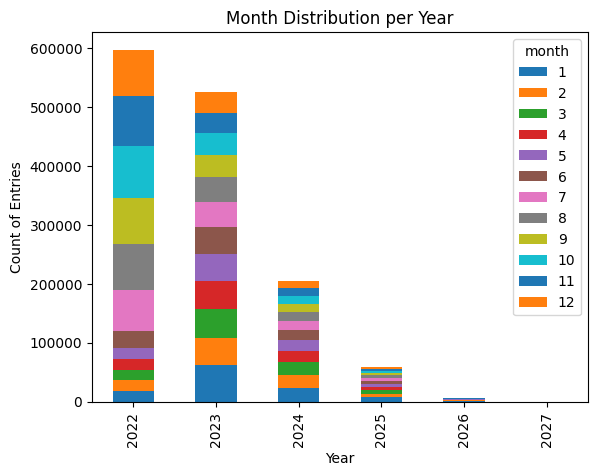

In [12]:
def plot_hist_df(df):
    df['date'] = pd.to_datetime(df['Time_step'])
    # Extract the year and month
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    # Plot the distribution of months per year
    df.groupby(['year', 'month']).size().unstack().plot(kind='bar', stacked=True)

    plt.xlabel('Year')
    plt.ylabel('Count of Entries')
    plt.title('Month Distribution per Year')
    plt.show()

plot_hist_df(aml_data)

In [22]:
aml_data['Label'].map({'GOOD': 0, 'BAD': 1})

0          0
1          0
2          0
3          0
4          0
          ..
1484531    0
1484532    0
1484533    0
1484534    0
1484535    0
Name: Label, Length: 1484536, dtype: int64

In [19]:
dt_norm_values = {
    'day': 'txn_age_days',
    'hour': 'txn_time_hr',
    'min': 'txn_time_mm',
}

dt_norm_values.values()

dict_values(['txn_age_days', 'txn_time_hr', 'txn_time_mm'])

In [20]:
['a', 'b'] + list(dt_norm_values.values())

['a', 'b', 'txn_age_days', 'txn_time_hr', 'txn_time_mm']

In [22]:
dt_norm_values['day']

'txn_age_days'

In [24]:
[dt_norm_values['day'], dt_norm_values['hour'], dt_norm_values['min']]


['txn_age_days', 'txn_time_hr', 'txn_time_mm']

In [24]:
example_usage()

,customer_id,amount,account_age,volume_7d_avg,volume_7d_std,volume_7d_count,volume_14d_avg,volume_14d_std,volume_14d_count,volume_30d_avg,volume_30d_std,volume_30d_count,volume_avg_7d_to_14d_ratio,volume_count_7d_to_14d_ratio,volume_avg_7d_to_30d_ratio,volume_count_7d_to_30d_ratio,volume_avg_14d_to_30d_ratio,volume_count_14d_to_30d_ratio
0,A1,100,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,A1,200,20,0.0,0.0,0.0,100.0,0.0,1.0,100.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.000000,2.142857
2,A1,150,30,0.0,0.0,0.0,200.0,0.0,1.0,150.0,70.710678,2.0,0.0,0.0,0.0,0.0,1.333333,1.071429
3,A2,300,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,A2,250,25,0.0,0.0,0.0,300.0,0.0,1.0,300.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.000000,2.142857


In [25]:
calculator = TransactionStatsCalculator(
        time_bins=[7, 14, 30],
        metrics=['avg', 'std', 'count'],
        ratio_pairs=[(7, 14), (7, 30), (14, 30)]
    )

test_data = calculator.process_transactions(
    df=aml_data,
    amount_col='USD_amount',
    customer_id_col='party_Id',
    age_col='txn_age_days'
)

test_data.to_parquet('../data/jp_morgan/test_data.parquet')

KeyboardInterrupt: 

In [34]:
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict
from tqdm.auto import tqdm
import multiprocessing as mp
from datetime import datetime
import gc
import warnings
warnings.filterwarnings('ignore')

class TransactionProcessor:
    def __init__(
        self,
        time_bins: List[int] = [7, 14, 30],
        amount_col: str = 'USD_amount',  # Updated
        customer_id_col: str = 'party_Id',  # Updated
        age_col: str = 'txn_age_days'  # Updated
    ):
        self.time_bins = time_bins
        self.amount_col = amount_col
        self.customer_id_col = customer_id_col
        self.age_col = age_col

    @staticmethod
    def calculate_customer_metrics(args: Tuple[pd.DataFrame, Dict]) -> pd.DataFrame:
        """Calculate metrics for a single customer's transactions"""
        customer_data, config = args
        result = customer_data.copy()
        
        # Get configuration
        time_bins = config['time_bins']
        amount_col = config['amount_col']
        age_col = config['age_col']
        
        # Sort by age
        result = result.sort_values(age_col)
        
        # Calculate metrics for each time bin
        for days in time_bins:
            result[f'volume_{days}d_avg'] = 0.0
            result[f'volume_{days}d_count'] = 0
            
            for idx in range(len(result)):
                current_age = result.iloc[idx][age_col]
                mask = (
                    (result[age_col] <= (current_age - 1)) & 
                    (result[age_col] > (current_age - days - 1))
                )
                window_data = result.loc[mask, amount_col]
                
                if len(window_data) > 0:
                    result.iloc[idx, result.columns.get_loc(f'volume_{days}d_avg')] = window_data.mean()
                    result.iloc[idx, result.columns.get_loc(f'volume_{days}d_count')] = len(window_data)
        
        return result

    def process_transactions(
        self,
        df: pd.DataFrame,
        n_jobs: int = None,
        batch_size: int = 1000
    ) -> pd.DataFrame:
        """Process all transactions using parallel processing"""
        if n_jobs is None:
            n_jobs = max(1, mp.cpu_count() - 1)
        
        print(f"Starting processing with {n_jobs} workers")
        print(f"Total transactions: {len(df):,}")
        print(f"Total customers: {df[self.customer_id_col].nunique():,}")
        
        # Sort data
        df = df.sort_values([self.customer_id_col, self.age_col])
        
        # Split customers into batches
        all_customers = df[self.customer_id_col].unique()
        customer_batches = [
            all_customers[i:i + batch_size] 
            for i in range(0, len(all_customers), batch_size)
        ]
        
        results = []
        config = {
            'time_bins': self.time_bins,
            'amount_col': self.amount_col,
            'age_col': self.age_col
        }
        
        print(f"Processing {len(customer_batches)} batches...")
        
        for batch_idx, customer_batch in enumerate(customer_batches, 1):
            print(f"\nProcessing batch {batch_idx}/{len(customer_batches)}")
            
            # Get data for current batch
            batch_data = df[df[self.customer_id_col].isin(customer_batch)]
            
            # Process this batch without multiprocessing
            batch_results = []
            for _, group in tqdm(batch_data.groupby(self.customer_id_col), 
                               desc="Processing customers in batch"):
                result = self.calculate_customer_metrics((group, config))
                batch_results.append(result)
            
            # Combine batch results
            if batch_results:
                batch_df = pd.concat(batch_results, ignore_index=True)
                results.append(batch_df)
            
            # Save intermediate results
            if batch_idx % 5 == 0:  # Save every 5 batches
                interim_df = pd.concat(results, ignore_index=True)
                interim_df.to_parquet(f'interim_results_batch_{batch_idx}.parquet')
            
            # Clear memory
            del batch_data, batch_results
            gc.collect()
        
        # Combine all results
        print("\nCombining all results...")
        result_df = pd.concat(results, ignore_index=True)
        
        # Calculate ratios
        print("Calculating ratios...")
        for days1, days2 in [(7, 14), (7, 30), (14, 30)]:
            # Average ratio
            result_df[f'volume_avg_{days1}d_to_{days2}d_ratio'] = (
                result_df[f'volume_{days1}d_avg'] / 
                result_df[f'volume_{days2}d_avg'].replace(0, np.nan)
            ).fillna(0)
            
            # Count ratio
            result_df[f'volume_count_{days1}d_to_{days2}d_ratio'] = (
                (result_df[f'volume_{days1}d_count'] / days1) /
                (result_df[f'volume_{days2}d_count'] / days2).replace(0, np.nan)
            ).fillna(0)
        
        return result_df

def process_with_monitoring(
    df: pd.DataFrame,
    time_bins: List[int] = [7, 14, 30],
    batch_size: int = 1000
) -> pd.DataFrame:
    """Process with monitoring"""
    import psutil
    import os
    
    process = psutil.Process(os.getpid())
    start_time = datetime.now()
    
    print(f"Start time: {start_time}")
    print(f"Initial memory usage: {process.memory_info().rss / 1024 / 1024:.2f} MB")
    
    try:
        # Initialize processor
        processor = TransactionProcessor(
            time_bins=time_bins,
            amount_col='USD_amount',
            customer_id_col='party_Id',
            age_col='txn_age_days'
        )
        
        # Process data
        result_df = processor.process_transactions(
            df=df,
            batch_size=batch_size
        )
        
        end_time = datetime.now()
        processing_time = end_time - start_time
        
        print("\nProcessing completed successfully!")
        print(f"End time: {end_time}")
        print(f"Total processing time: {processing_time}")
        print(f"Final memory usage: {process.memory_info().rss / 1024 / 1024:.2f} MB")
        
        return result_df
        
    except Exception as e:
        print(f"\nError during processing: {str(e)}")
        raise

# Example usage
if __name__ == "__main__":
    # Read your data
    df = aml_data.copy()  # or however you load your data
    
    # Process with monitoring
    result_df = process_with_monitoring(
        df=df,
        time_bins=[7, 14, 30],
        batch_size=1000  # Process 1000 customers at a time
    )
    
    # Save final results
    result_df.to_parquet('transaction_metrics_final.parquet')

Start time: 2024-10-28 10:31:36.039344
Initial memory usage: 984.64 MB
Starting processing with 7 workers
Total transactions: 1,391,164
Total customers: 31,259
Processing 32 batches...

Processing batch 1/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:51<00:00, 19.47it/s]



Processing batch 2/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:53<00:00, 18.77it/s]



Processing batch 3/32


Processing customers in batch: 100%|██████████| 1000/1000 [01:06<00:00, 15.08it/s]



Processing batch 4/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:54<00:00, 18.44it/s]



Processing batch 5/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:54<00:00, 18.49it/s]



Processing batch 6/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:52<00:00, 19.03it/s]



Processing batch 7/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:54<00:00, 18.30it/s]



Processing batch 8/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:53<00:00, 18.58it/s]



Processing batch 9/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:56<00:00, 17.81it/s]



Processing batch 10/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:52<00:00, 18.92it/s]



Processing batch 11/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:54<00:00, 18.28it/s]



Processing batch 12/32


Processing customers in batch: 100%|██████████| 1000/1000 [01:02<00:00, 16.11it/s]



Processing batch 13/32


Processing customers in batch: 100%|██████████| 1000/1000 [01:01<00:00, 16.29it/s]



Processing batch 14/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:56<00:00, 17.77it/s]



Processing batch 15/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:56<00:00, 17.56it/s]



Processing batch 16/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:54<00:00, 18.31it/s]



Processing batch 17/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:56<00:00, 17.82it/s]



Processing batch 18/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:55<00:00, 18.05it/s]



Processing batch 19/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:52<00:00, 19.08it/s]



Processing batch 20/32


Processing customers in batch: 100%|██████████| 1000/1000 [01:02<00:00, 16.07it/s]



Processing batch 21/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:53<00:00, 18.62it/s]



Processing batch 22/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:59<00:00, 16.87it/s]



Processing batch 23/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:59<00:00, 16.85it/s]



Processing batch 24/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:59<00:00, 16.79it/s]



Processing batch 25/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:54<00:00, 18.25it/s]



Processing batch 26/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:52<00:00, 18.91it/s]



Processing batch 27/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:56<00:00, 17.65it/s]



Processing batch 28/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:54<00:00, 18.38it/s]



Processing batch 29/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:55<00:00, 17.99it/s]



Processing batch 30/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:53<00:00, 18.58it/s]



Processing batch 31/32


Processing customers in batch: 100%|██████████| 1000/1000 [00:53<00:00, 18.77it/s]



Processing batch 32/32


Processing customers in batch: 100%|██████████| 259/259 [00:16<00:00, 15.35it/s]



Combining all results...
Calculating ratios...

Processing completed successfully!
End time: 2024-10-28 11:01:30.404093
Total processing time: 0:29:54.364749
Final memory usage: 1191.69 MB


In [29]:
def process_with_checkpoints(df):
    # Create checkpoint directory
    import os
    os.makedirs('checkpoints', exist_ok=True)
    
    try:
        result_df = process_with_monitoring(
            df=df,
            customer_id_col='party_Id',
            amount_col='USD_amount',
            age_col='txn_age_days',
            n_jobs=mp.cpu_count() - 1  # Use all but one CPU
        )
        
        # Save final result
        result_df.to_parquet('checkpoints/final_result.parquet')
        print("Results saved to 'checkpoints/final_result.parquet'")
        
        return result_df
        
    except KeyboardInterrupt:
        print("\nProcessing interrupted by user")
        return None
    
process_with_checkpoints(aml_data)

Start time: 2024-10-28 10:27:01.990756
Initial memory usage: 20.56 MB
Starting processing with 7 workers
Total transactions: 1,391,164
Total customers: 31,259


Process SpawnPoolWorker-5:
Traceback (most recent call last):
Process SpawnPoolWorker-6:
Traceback (most recent call last):
Process SpawnPoolWorker-7:
Process SpawnPoolWorker-4:
Traceback (most recent call last):
Process SpawnPoolWorker-8:
Traceback (most recent call last):
  File "/Users/UDAmiel/Documents/AMIEL/[Personal] Git/.conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/UDAmiel/Documents/AMIEL/[Personal] Git/.conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/UDAmiel/Documents/AMIEL/[Personal] Git/.conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/UDAmiel/Documents/AMIEL/[Personal] Git/.conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/UDAmiel/Documents/AMIEL/[Personal] Git/.conda/lib/python3.11/multiprocessing/pool.py",


Processing interrupted by user


In [1]:
import polars as pl

: 

In [ ]:
df_pl = pl.read_parquet('transaction_metrics_final.parquet')